In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Helper Functions

In [64]:
def get_admittance_data(path, time_col='ros_time_sec', norm_time_col=False):
    """
    This function retrieves the admittance data for
    both Monica and Ross from the specified path.

    @param path: The path to the directory containing the csv files.
    @param time_col: The name of the time column to use for merging.
    @param norm_time_col: Whether to normalize the time column
        (subtract each timestamp from the smallest timestamp).

    """
    monica_data = pd.read_csv(path + 'monica_admittance_data.csv')
    ross_data = pd.read_csv(path + 'ross_admittance_data.csv')

    # save everything to a single dataframe
    time_series_df = pd.merge(
        monica_data,
        ross_data,
        on=time_col,
        how='outer',
        # appends suffixes to the column names
        # from the original dataframes
        suffixes=('_monica', '_ross')
    ).sort_values(time_col).reset_index(drop=True)

    # normalize time column
    if norm_time_col:
        time_series_df[time_col] = time_series_df[time_col] - \
            time_series_df[time_col].min()

    # fill in null values
    # time_series = time_series.set_index('time_sec')
    # time_series = time_series.interpolate(method='time').reset_index()
    time_series_df = time_series_df.interpolate(method='linear')
    # fill in NaN values
    time_series_df = time_series_df.fillna(method='bfill')

    return time_series_df

def merge_traj_and_admittance_data(traj_df, admittance_df, time_col='ros_time_sec'):
    """
    Merge the trajectory and admittance data on the time column.

    @param traj_df: The trajectory dataframe.
    @param admittance_df: The admittance dataframe.
    @return: The merged dataframe.
    """
    merged_df = pd.merge_asof(
        traj_df,
        admittance_df,
        on=time_col,
        direction='nearest',
        # dataframes share no important columns
        # so this is unnecessary
        # suffixes=('_traj', '_admittance')
    )
    return merged_df

## Plotting Functions

In [65]:
def plot_traj_and_force(
        merged_df,
        time_col='ros_time_sec',
        fig_size=(18, 8),
        ross_color='blue',
        monica_color='red',
        payload_color='green',
        desired_line_style='-',
        actual_line_style='--'
    ):
    fig, axes = plt.subplots(
        nrows=2,
        ncols=1,
        figsize=fig_size,
    )

    # plot trajectories
    axes[0].plot(
        merged_df['act_mon_x'],
        merged_df['act_mon_y'],
        label='Monica\'s actual trajectory',
        color=monica_color,
        linestyle=actual_line_style,
        markersize=6
    )
    axes[0].plot(
        merged_df['des_mon_x'],
        merged_df['des_mon_y'],
        label='Monica\'s desired trajectory',
        color=monica_color,
        linestyle=desired_line_style,
        markersize=6
    )
    axes[0].plot(
        merged_df['act_ross_x'],
        merged_df['act_ross_y'],
        label='Ross\'s actual trajectory',
        color=ross_color,
        linestyle=actual_line_style,
        markersize=6
    )
    axes[0].plot(
        merged_df['des_ross_x'],
        merged_df['des_ross_y'],
        label='Ross\'s desired trajectory',
        color=ross_color,
        linestyle=desired_line_style,
        markersize=6
    )
    axes[0].plot(
        merged_df['act_payload_x'],
        merged_df['act_payload_y'],
        label='Payload\'s actual trajectory',
        color=payload_color,
        linestyle='-',
        markersize=6
    )
    axes[0].set_xlabel('x (m)')
    axes[0].set_ylabel('y (m)')
    axes[0].set_title('Actual Trajectories')
    axes[0].legend()
    axes[0].grid(True)

    # plot forces
    axes[1].plot(
        merged_df['act_payload_x'],
        merged_df['force_monica'],
        label="Monica's force",
        color=monica_color
    )
    axes[1].plot(
        merged_df['act_payload_x'],
        merged_df['force_ross'],
        label="Ross's force",
        color=ross_color
    )
    axes[1].set_xlabel('Payload X Position (m)')
    axes[1].set_ylabel('Force (N)')
    axes[1].set_title('Force vs Payload X Position')
    axes[1].legend()
    axes[1].grid(True)

    fig.tight_layout()



    


## Plotting / Data Analysis

In [66]:
csv_path = '../../data/08-30_dataset/08-30_a_experiments/08-30_a_trial_01/'

traj_df = pd.read_csv(csv_path + 'trajectory_data.csv')

traj_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1501 entries, 0 to 1500
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   des_ross_x                1501 non-null   float64
 1   des_ross_y                1501 non-null   float64
 2   des_ross_theta            1501 non-null   float64
 3   des_mon_x                 1501 non-null   float64
 4   des_mon_y                 1501 non-null   float64
 5   des_mon_theta             1501 non-null   float64
 6   act_ross_x                1501 non-null   float64
 7   act_ross_y                1501 non-null   float64
 8   act_ross_theta            1501 non-null   float64
 9   act_mon_x                 1501 non-null   float64
 10  act_mon_y                 1501 non-null   float64
 11  act_mon_theta             1501 non-null   float64
 12  act_payload_x             1501 non-null   float64
 13  act_payload_y             1501 non-null   float64
 14  act_payl

In [67]:
admittance_df = get_admittance_data(csv_path, time_col='ros_time_ns', norm_time_col=False)

admittance_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67702 entries, 0 to 67701
Data columns (total 35 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   t_p_x_monica         67702 non-null  float64
 1   t_p_y_monica         67702 non-null  float64
 2   t_p_z_monica         67702 non-null  float64
 3   t_w_monica           67702 non-null  float64
 4   t_x_monica           67702 non-null  float64
 5   t_y_monica           67702 non-null  float64
 6   t_z_monica           67702 non-null  float64
 7   v_p_x_monica         67702 non-null  float64
 8   v_p_y_monica         67702 non-null  float64
 9   v_p_z_monica         67702 non-null  float64
 10  v_w_monica           67702 non-null  float64
 11  v_x_monica           67702 non-null  float64
 12  v_y_monica           67702 non-null  float64
 13  v_z_monica           67702 non-null  float64
 14  force_monica         67702 non-null  float64
 15  stiffness_monica     67702 non-null 

/tmp/ipykernel_25532/101406261.py:36: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  time_series_df = time_series_df.fillna(method='bfill')


In [68]:
merged_df = merge_traj_and_admittance_data(traj_df, admittance_df, time_col='ros_time_ns')

merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1501 entries, 0 to 1500
Data columns (total 56 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   des_ross_x                1501 non-null   float64
 1   des_ross_y                1501 non-null   float64
 2   des_ross_theta            1501 non-null   float64
 3   des_mon_x                 1501 non-null   float64
 4   des_mon_y                 1501 non-null   float64
 5   des_mon_theta             1501 non-null   float64
 6   act_ross_x                1501 non-null   float64
 7   act_ross_y                1501 non-null   float64
 8   act_ross_theta            1501 non-null   float64
 9   act_mon_x                 1501 non-null   float64
 10  act_mon_y                 1501 non-null   float64
 11  act_mon_theta             1501 non-null   float64
 12  act_payload_x             1501 non-null   float64
 13  act_payload_y             1501 non-null   float64
 14  act_payl

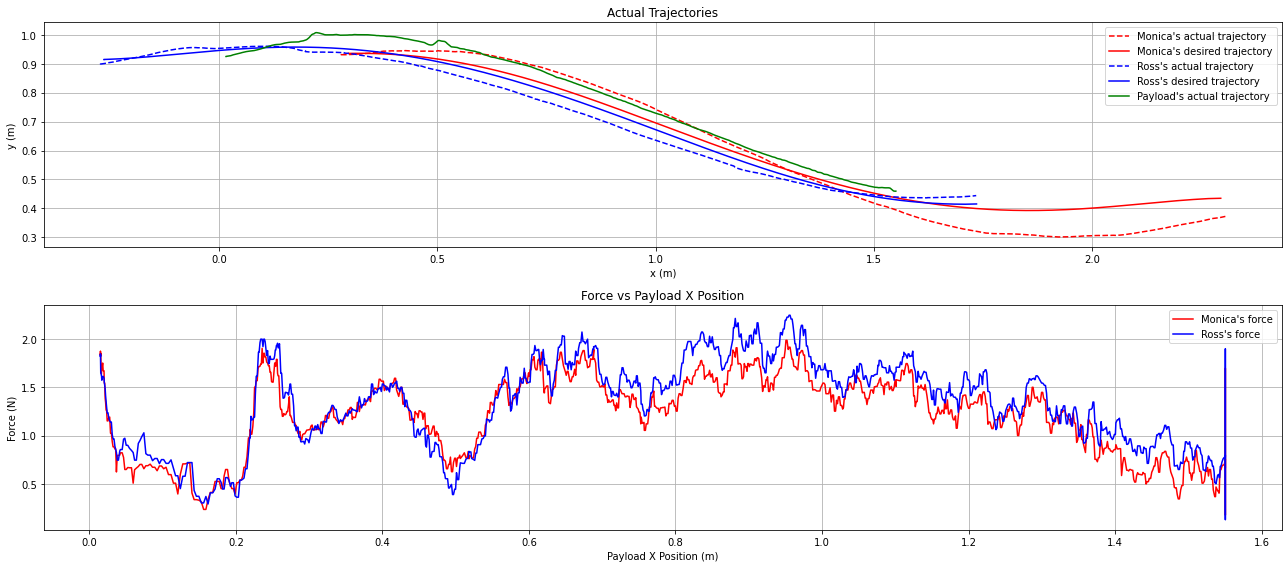

In [69]:
plot_traj_and_force(merged_df)